In [ ]:
#| hide
#| default_exp simple_sentence_similarity

In [ ]:
#| hide
%matplotlib inline
from nbdev.showdoc import *

# Simple Sentence Similarity
(follows: https://github.com/nlptown/nlp-notebooks/blob/master/Simple%20Sentence%20Similarity.ipynb)

## Data

### STS Benchmark

The STS Benchmark gathers the English data from the SemEval sentence similarity tasks (2012-2017). The data is split in training, development, and test data (uri: http://ixa2.si.ehu.es/stswiki/index.php/STSbenchmark).

In [ ]:
#| export
import pandas as pd
import numpy as np
import scipy
import math
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import requests
import gensim
from gensim.models import Word2Vec
from gensim.scripts.glove2word2vec import glove2word2vec
import csv
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from collections import Counter
import torch
import tensorflow_hub as hub
import functools as ft

2022-09-08 09:44:23.216109: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-08 09:44:23.362799: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-08 09:44:23.392617: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-08 09:44:23.944077: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [ ]:
#| export
def load_sts_dataset(filename):
  """ Loads a subset of the STS dataset into a DataFrame. In particular both sentences and their human rated similarity score."""
  sent_pairs = []
  with open(filename, "r") as f:
    for line in f:
      ts = line.strip().split('\t')
      sent_pairs.append((ts[5], ts[6], float(ts[4])))
  return pd.DataFrame(sent_pairs, columns=["sent_1", "sent_2", "sim"])

"""
# commented out: We will use the local downloaded files
def download_and_load_sts_data():
  # We will grab the STS datasets from their website.
  sts_dataset = tf.keras.utils.get_file(
    fname="Stsbenchmark.tar.gz",
    origin="http://ixa2.si.ehu.es/stswiki/images/4/48/Stsbenchmark.tar.gz",
    extract=True
  )
"""

sts_dev = load_sts_dataset('/home/peter/Documents/data/nlp/stsbenchmark/sts-dev.csv')
sts_test = load_sts_dataset('/home/peter/Documents/data/nlp/stsbenchmark/sts-test.csv')

In [ ]:
#| hide
sts_dev[:5]

,sent_1,sent_2,sim
0,A man with a hard hat is dancing.,A man wearing a hard hat is dancing.,5.00
1,A young child is riding a horse.,A child is riding a horse.,4.75
2,A man is feeding a mouse to a snake.,The man is feeding a mouse to the snake.,5.00
3,A woman is playing the guitar.,A man is playing guitar.,2.40
4,A woman is playing the flute.,A man is playing a flute.,2.75


In [ ]:
#| hide
sts_test[:5]

,sent_1,sent_2,sim
0,A girl is styling her hair.,A girl is brushing her hair.,2.5
1,A group of men play soccer on the beach.,A group of boys are playing soccer on the beach.,3.6
2,One woman is measuring another woman's ankle.,A woman measures another woman's ankle.,5.0
3,A man is cutting up a cucumber.,A man is slicing a cucumber.,4.2
4,A man is playing a harp.,A man is playing a keyboard.,1.5


### SICK data

The SICK dataset contains 10_000 English sentence pairs labelled with their semantic relatedness and entailment relation.

In [ ]:
#| export
def download_sick(f): 

    response = requests.get(f).text

    lines = response.split("\n")[1:]
    lines = [l.split("\t") for l in lines if len(l) > 0]
    lines = [l for l in lines if len(l) == 5]

    df = pd.DataFrame(lines, columns=["idx", "sent_1", "sent_2", "sim", "label"])
    df['sim'] = pd.to_numeric(df['sim'])
    return df
    
sick_train = download_sick("https://raw.githubusercontent.com/alvations/stasis/master/SICK-data/SICK_train.txt")
sick_dev = download_sick("https://raw.githubusercontent.com/alvations/stasis/master/SICK-data/SICK_trial.txt")
sick_test = download_sick("https://raw.githubusercontent.com/alvations/stasis/master/SICK-data/SICK_test_annotated.txt")
sick_all = pd.concat([sick_train, sick_test, sick_dev])

In [ ]:
#| test
sick_all[:5]

,idx,sent_1,sent_2,sim,label
0,1,A group of kids is playing in a yard and an ol...,A group of boys in a yard is playing and a man...,4.5,NEUTRAL
1,2,A group of children is playing in the house an...,A group of kids is playing in a yard and an ol...,3.2,NEUTRAL
2,3,The young boys are playing outdoors and the ma...,The kids are playing outdoors near a man with ...,4.7,ENTAILMENT
3,5,The kids are playing outdoors near a man with ...,A group of kids is playing in a yard and an ol...,3.4,NEUTRAL
4,9,The young boys are playing outdoors and the ma...,A group of kids is playing in a yard and an ol...,3.7,NEUTRAL


## Preparation

Some of the models we will use require **tokenization** , others do not require it. We define a simple `sentence` class where we keep both the raw sentence and the tokenized sentence. The individual methods then can pick the input they need.

In [ ]:
#| export
STOP = set(nltk.corpus.stopwords.words('english'))

class Sentence:
  def __init__(self, sentence):
    self.raw = sentence
    normalized_sentence = sentence.replace("‘", "'").replace("’", "'")
    self.tokens = [t.lower() for t in nltk.word_tokenize(normalized_sentence)]
    self.tokens_without_stop = [t for t in self.tokens if t not in STOP]

The author of the NB uses two pre-trained word embeddings: `word2vec` and `GloVe` via the `gensim` library. GloVe gives some trouble, because it needs to be converted into word2vec format (which takes > 10 minutes). So, we skip the GloVe word embeddings here.

In [ ]:
#| export
PATH_TO_WORD2VEC = os.path.expanduser("~/Documents/data/nlp/GoogleNews-vectors-negative300.bin")
PATH_TO_GLOVE = os.path.expanduser("~/Documents/data/nlp/glove.840B.300d.txt")

word2vec = gensim.models.KeyedVectors.load_word2vec_format(PATH_TO_WORD2VEC, binary=True)

In order to be able to compute weighted averages of word embedding in a later stage, we are going to load a file with word freqs that have been collected from Wikipedia:

In [ ]:
#| export
PATH_TO_FREQUENCIES_FILE = os.path.expanduser('~/Documents/data/nlp/frequencies.tsv')
PATH_TO_DOC_FREQUENCIES_FILE = os.path.expanduser('~/Documents/data/nlp/doc_frequencies.tsv')

def read_tsv(f):
  frequencies = {}
  with open(f) as tsv:
    tsv_reader = csv.reader(tsv, delimiter='\t')
    for row in tsv_reader:
      frequencies[row[0]] = int(row[1])
  return frequencies

frequencies = read_tsv(PATH_TO_FREQUENCIES_FILE)
doc_frequencies = read_tsv(PATH_TO_DOC_FREQUENCIES_FILE)
doc_frequencies["NUM_DOCS"] = 1_288_431

In [ ]:
#| hide
len(doc_frequencies)

3388135

## Similarity methods

### Baseline

The simplest way of computing sentence embeddings is taking the embeddings of words in the sentence, minus the stopwords, and compute their average, weighted by the sentence frequency of each word.

Then we can use **cosine similarity** to calculate the distance between two sentence embeddings:

In [ ]:
#| export
def run_avg_benchmark(sentences1, sentences2, model=None, use_stoplist=False, doc_freqs=None):
  if doc_freqs is not None:
    N = doc_freqs['NUM_DOCS']

  sims = []
  for (sent1, sent2) in zip(sentences1, sentences2):
    tokens1 = sent1.tokens_without_stop if use_stoplist else sent1.tokens
    tokens2 = sent2.tokens_without_stop if use_stoplist else sent2.tokens

    tokens1 = [token for token in tokens1 if token in model]
    tokens2 = [token for token in tokens2 if token in model]

    if len(tokens1) == 0 or len(tokens2) == 0:
      sims.append(0)
      continue

    tokfreqs1 = Counter(tokens1)
    tokfreqs2 = Counter(tokens2)
  
    weights1 = [tokfreqs1[token] * math.log(N/(doc_freqs.get(token, 0)+1)) 
                for token in tokfreqs1] if doc_freqs else None
    weights2 = [tokfreqs2[token] * math.log(N/(doc_freqs.get(token, 0)+1)) 
                for token in tokfreqs2] if doc_freqs else None
                
    embedding1 = np.average([model[token] for token in tokfreqs1], axis=0, weights=weights1).reshape(1, -1)
    embedding2 = np.average([model[token] for token in tokfreqs2], axis=0, weights=weights2).reshape(1, -1)

    sim = cosine_similarity(embedding1, embedding2)[0][0]
    sims.append(sim)

  return sims

### Word Mover's Distance (WMD)

WMD is an alternative to simple average embeddings similarity. It uses the word embeddings of the words in two texts to measure the minimum amount that the words in text 1 need to "travel" in **semantic space** to reach the words in text 2. WMD is available in the `gensim` library.

In [ ]:
#| export
def run_wmd_benchmark(sentences1, sentences2, model, use_stoplist=False):
    
  sims = []
  for (sent1, sent2) in zip(sentences1, sentences2):
    
    tokens1 = sent1.tokens_without_stop if use_stoplist else sent1.tokens
    tokens2 = sent2.tokens_without_stop if use_stoplist else sent2.tokens
        
    tokens1 = [token for token in tokens1 if token in model]
    tokens2 = [token for token in tokens2 if token in model]
        
    if len(tokens1) == 0 or len(tokens2) == 0:
      tokens1 = [token for token in sent1.tokens if token in model]
      tokens2 = [token for token in sent2.tokens if token in model]
            
    sims.append(-model.wmdistance(tokens1, tokens2))
        
  return sims

### Smooth Inverse Frequency (SIF)

Taking the average of the word embeddings in a sentence is a crude procedure: Too much weight is given to irrelevant words. SIF tries to remedy this problem.

With SIF sentence embeddings:

1. we first compute a weighted average of token embeddings in a sentence with a different weight procedure
2. we apply common component removal (removing high-freq words that have just a syntactical function: just, but, etc.)

In [ ]:
#| export
def remove_first_principal_component(X):
  svd = TruncatedSVD(n_components=1, n_iter=7, random_state=0)
  svd.fit(X)
  pc = svd.components_
  XX = X - X.dot(pc.transpose()) * pc
  return XX


def run_sif_benchmark(sentences1, sentences2, model, freqs={}, use_stoplist=False, a=0.001): 
  total_freq = sum(freqs.values())

  embeddings = []

  # SIF requires us to first collect all sentence embeddings and then perform 
  # common component analysis.
  for (sent1, sent2) in zip(sentences1, sentences2): 
      
    tokens1 = sent1.tokens_without_stop if use_stoplist else sent1.tokens
    tokens2 = sent2.tokens_without_stop if use_stoplist else sent2.tokens
      
    tokens1 = [token for token in tokens1 if token in model]
    tokens2 = [token for token in tokens2 if token in model]
      
    weights1 = [a/(a+freqs.get(token,0)/total_freq) for token in tokens1]
    weights2 = [a/(a+freqs.get(token,0)/total_freq) for token in tokens2]
      
    embedding1 = np.average([model[token] for token in tokens1], axis=0, weights=weights1)
    embedding2 = np.average([model[token] for token in tokens2], axis=0, weights=weights2)
      
    embeddings.append(embedding1)
    embeddings.append(embedding2)
      
  embeddings = remove_first_principal_component(np.array(embeddings))
  sims = [cosine_similarity(embeddings[idx*2].reshape(1, -1), 
                            embeddings[idx*2+1].reshape(1, -1))[0][0] 
          for idx in range(int(len(embeddings)/2))]

  return sims

Both methods above are BOW methods -- they do not take word order into account.
Both times the word embeddings are learned in an **unsupervised** manner.

Perhaps we can do better if we do base our embeddings on word order and used **supervised** training.

### Experiments

We could not reproduce the GloVe, Infersents and GSE experiments.

In [ ]:
#| export
def run_experiment(df, benchmarks): 
    
    sentences1 = [Sentence(s) for s in df['sent_1']]
    sentences2 = [Sentence(s) for s in df['sent_2']]
    
    pearson_cors, spearman_cors = [], []
    for label, method in benchmarks:
        sims = method(sentences1, sentences2)
        pearson_correlation = scipy.stats.pearsonr(sims, df['sim'])[0]
        print(label, pearson_correlation)
        pearson_cors.append(pearson_correlation)
        spearman_correlation = scipy.stats.spearmanr(sims, df['sim'])[0]
        spearman_cors.append(spearman_correlation)
        
    return pearson_cors, spearman_cors

In [ ]:
#| export
benchmarks = [("AVG-W2V", ft.partial(run_avg_benchmark, model=word2vec, use_stoplist=False)),
              ("AVG-W2V-STOP", ft.partial(run_avg_benchmark, model=word2vec, use_stoplist=True)),
              ("AVG-W2V-TFIDF", ft.partial(run_avg_benchmark, model=word2vec, use_stoplist=False, doc_freqs=doc_frequencies)),
              ("AVG-W2V-TFIDF-STOP", ft.partial(run_avg_benchmark, model=word2vec, use_stoplist=True, doc_freqs=doc_frequencies)),
              ("WMD-W2V", ft.partial(run_wmd_benchmark, model=word2vec, use_stoplist=False)), 
              ("WMD-W2V-STOP", ft.partial(run_wmd_benchmark, model=word2vec, use_stoplist=True)), 
              ("SIF-W2V", ft.partial(run_sif_benchmark, freqs=frequencies, model=word2vec, use_stoplist=False)),
]

pearson_results, spearman_results = {}, {}
pearson_results["SICK-DEV"], spearman_results["SICK-DEV"] = run_experiment(sick_dev, benchmarks)
pearson_results["SICK-TEST"], spearman_results["SICK-TEST"] = run_experiment(sick_test, benchmarks)
pearson_results["STS-DEV"], spearman_results["STS-DEV"] = run_experiment(sts_dev, benchmarks)
pearson_results["STS-TEST"], spearman_results["STS-TEST"] = run_experiment(sts_test, benchmarks) 

AVG-W2V 0.7165220637923075
AVG-W2V-STOP 0.7014898775706087
AVG-W2V-TFIDF 0.7096471932652145
AVG-W2V-TFIDF-STOP 0.6994376660669077
WMD-W2V 0.6257507950730131
WMD-W2V-STOP 0.6361876534824065
SIF-W2V 0.7252383011188148
AVG-W2V 0.7296376445303951
AVG-W2V-STOP 0.7140806503315156
AVG-W2V-TFIDF 0.6928386300519529
AVG-W2V-TFIDF-STOP 0.6868900348081443
WMD-W2V 0.6181445400062197
WMD-W2V-STOP 0.6256119028031648
SIF-W2V 0.729060153111828
AVG-W2V 0.7146253519592431
AVG-W2V-STOP 0.751154885130374
AVG-W2V-TFIDF 0.7440319663788372
AVG-W2V-TFIDF-STOP 0.744428767312474
WMD-W2V 0.6499437974825442
WMD-W2V-STOP 0.7186238584902462
SIF-W2V 0.7675717610296409
AVG-W2V 0.6245303875861393
AVG-W2V-STOP 0.6094885355928743
AVG-W2V-TFIDF 0.6399221957852945
AVG-W2V-TFIDF-STOP 0.5876303025000269
WMD-W2V 0.5517199370744937
WMD-W2V-STOP 0.653875367178549
SIF-W2V 0.6897612189058901


### Conclusions sofar

We were not able to reproduce results for:

- the glove model. Did not compile with current stack
- the FB Infersent embeddings
- the Google Sentence Encoder embeddings

That leaves us with the word2vec results. Which is not bad at all. This simple model outperforms GloVe.

In [ ]:
#| export
plt.rcParams['figure.figsize'] = (10,5)

pearson_results_df = pd.DataFrame(pearson_results)
pearson_results_df = pearson_results_df.transpose()
pearson_results_df = pearson_results_df.rename(columns={i:b[0] for i, b in enumerate(benchmarks)})

spearman_results_df = pd.DataFrame(spearman_results)
spearman_results_df = spearman_results_df.transpose()
spearman_results_df = spearman_results_df.rename(columns={i:b[0] for i, b in enumerate(benchmarks)})

<matplotlib.legend.Legend>

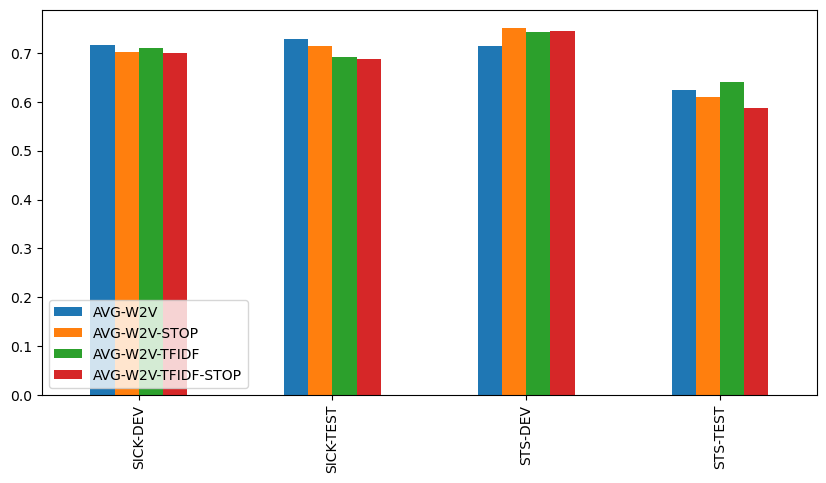

In [ ]:
#| hide
pearson_results_df[[b[0] for b in benchmarks if b[0].startswith("AVG")]].plot(kind="bar").legend(loc="lower left")

<matplotlib.legend.Legend>

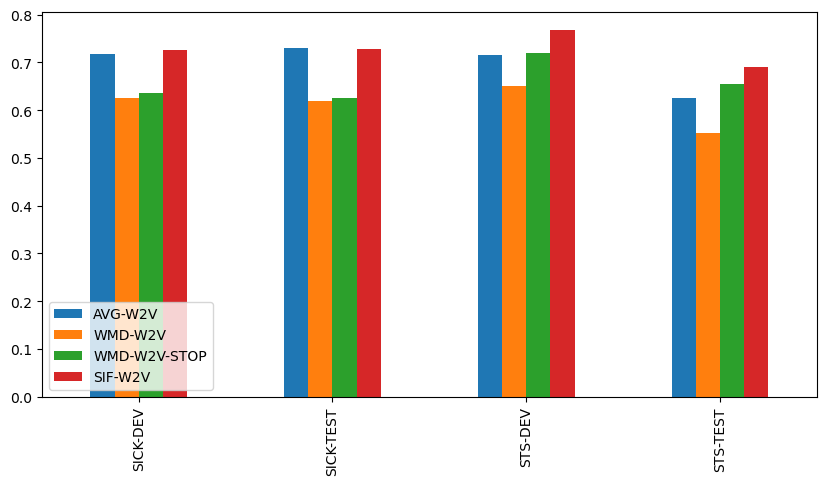

In [ ]:
#| hide
pearson_results_df[["AVG-W2V", "WMD-W2V", "WMD-W2V-STOP", "SIF-W2V"]].plot(kind="bar").legend(loc="lower left")

## Conclusions

- word2vec embeddings are a good choice for computing sentence similarity
- SIF outperforms yje unweighted average of word embeddings
- Pre-trained encoders do NOT add a spectacular gain, if they add anything at all.